Skipping file /kaggle/input/animal-dataset/animal_dataset_intermediate/train/pecora_train/filenames.txt, error: cannot identify image file <_io.BytesIO object at 0x7eebb9515a80>
Skipping file /kaggle/input/animal-dataset/animal_dataset_intermediate/train/elefante_train/filenames_elefante_train.txt, error: cannot identify image file <_io.BytesIO object at 0x7eebb928f8d0>
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 40s 76ms/step - accuracy: 0.9167 - loss: 0.2928 - val_accuracy: 0.9756 - val_loss: 0.0774 - learning_rate: 0.0010
Epoch 2/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.9585 - loss: 0.1377 - val_accuracy: 0.9701 - val_loss: 0.0852 - learning_rate: 0.0010
Epoch 3/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9683 - loss: 0.0983 - val_accuracy: 0.9665 - val_loss: 0.0861 - learning_rate: 0.0010
Epoch 4/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.9681 - loss: 0.1004 - val_accuracy: 0.9726 - v

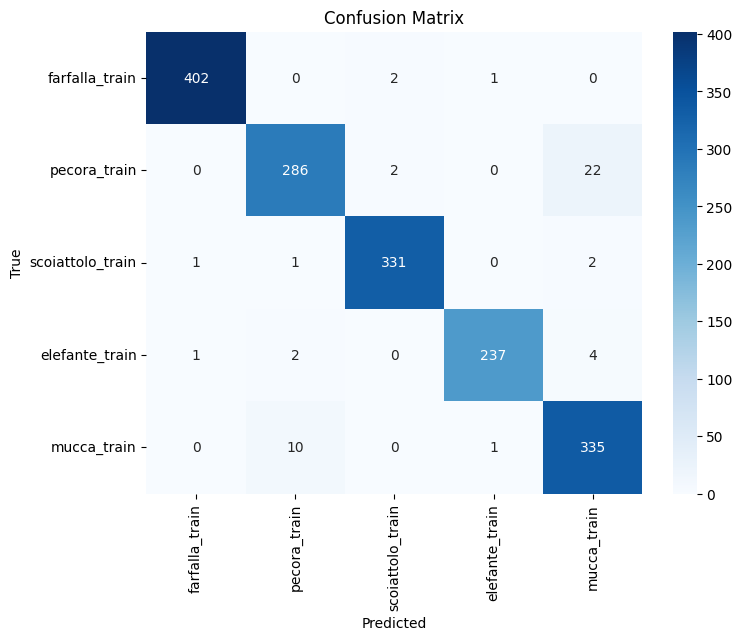

                  precision    recall  f1-score   support

  farfalla_train       1.00      0.99      0.99       405
    pecora_train       0.96      0.92      0.94       310
scoiattolo_train       0.99      0.99      0.99       335
  elefante_train       0.99      0.97      0.98       244
     mucca_train       0.92      0.97      0.94       346

        accuracy                           0.97      1640
       macro avg       0.97      0.97      0.97      1640
    weighted avg       0.97      0.97      0.97      1640



In [1]:
from tensorflow.keras.preprocessing import image
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Clear session
tf.keras.backend.clear_session()

# Define the directory for training data
train_dir = '/kaggle/input/animal-dataset/animal_dataset_intermediate/train'  # Replace with your train data path

# Image size
img_size = (224, 224)  # ResNet50 expects 224x224 images

# List the animal classes (subfolders in your dataset)
animal_classes = os.listdir(train_dir)
num_classes = len(animal_classes)

# Function to load images from directories and preprocess them
def load_images_from_directory(directory, img_size=(224, 224)):
    images = []
    labels = []
    for idx, animal_class in enumerate(animal_classes):
        class_folder = os.path.join(directory, animal_class)
        for filename in os.listdir(class_folder):
            file_path = os.path.join(class_folder, filename)
            try:
                img = image.load_img(file_path, target_size=img_size)
                img_array = image.img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
                images.append(img_array)
                labels.append(idx)
            except Exception as e:
                print(f"Skipping file {file_path}, error: {e}")
    return np.array(images), np.array(labels)

# Now use this function to load the dataset
X, y = load_images_from_directory(train_dir)

# Split the dataset into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Clear session for fresh model
tf.keras.backend.clear_session()

from tensorflow.keras.applications import Xception

base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))



# Freeze the layers of the pre-trained ResNet50 model
base_model.trainable = False

# Create the classification head
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(num_classes, activation='softmax')(x)

# Create the final model
model = models.Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning rate reduction callback
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    min_lr=1e-6, 
    verbose=1
)

# Train the model with ReduceLROnPlateau callback
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[lr_reduction]  # Add the learning rate reduction here
)

# Evaluate the model on the validation data
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)  # Get predicted class labels

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)

# Classification Report
cr = classification_report(y_val, y_pred, target_names=animal_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=animal_classes, yticklabels=animal_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print Classification Report
print(cr)


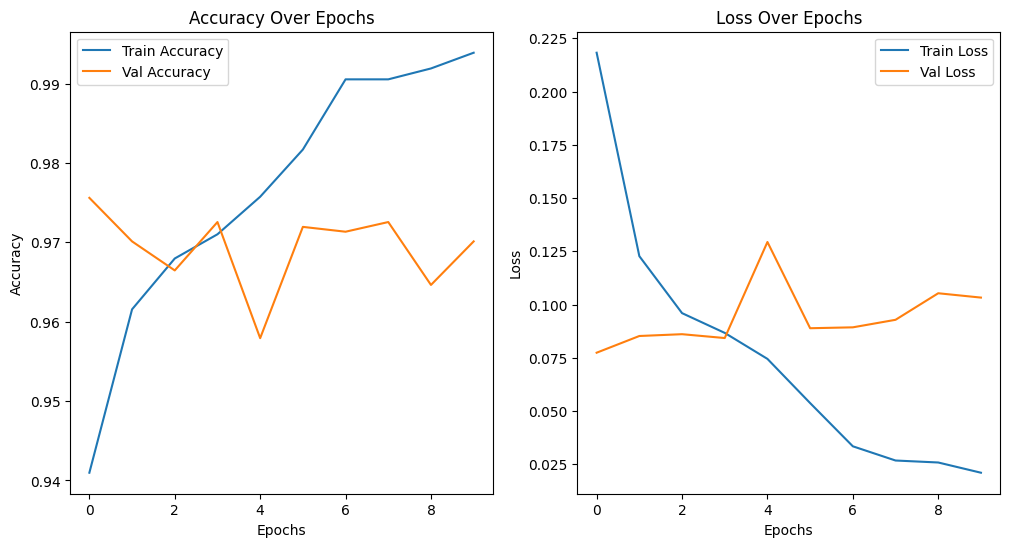

In [3]:
import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

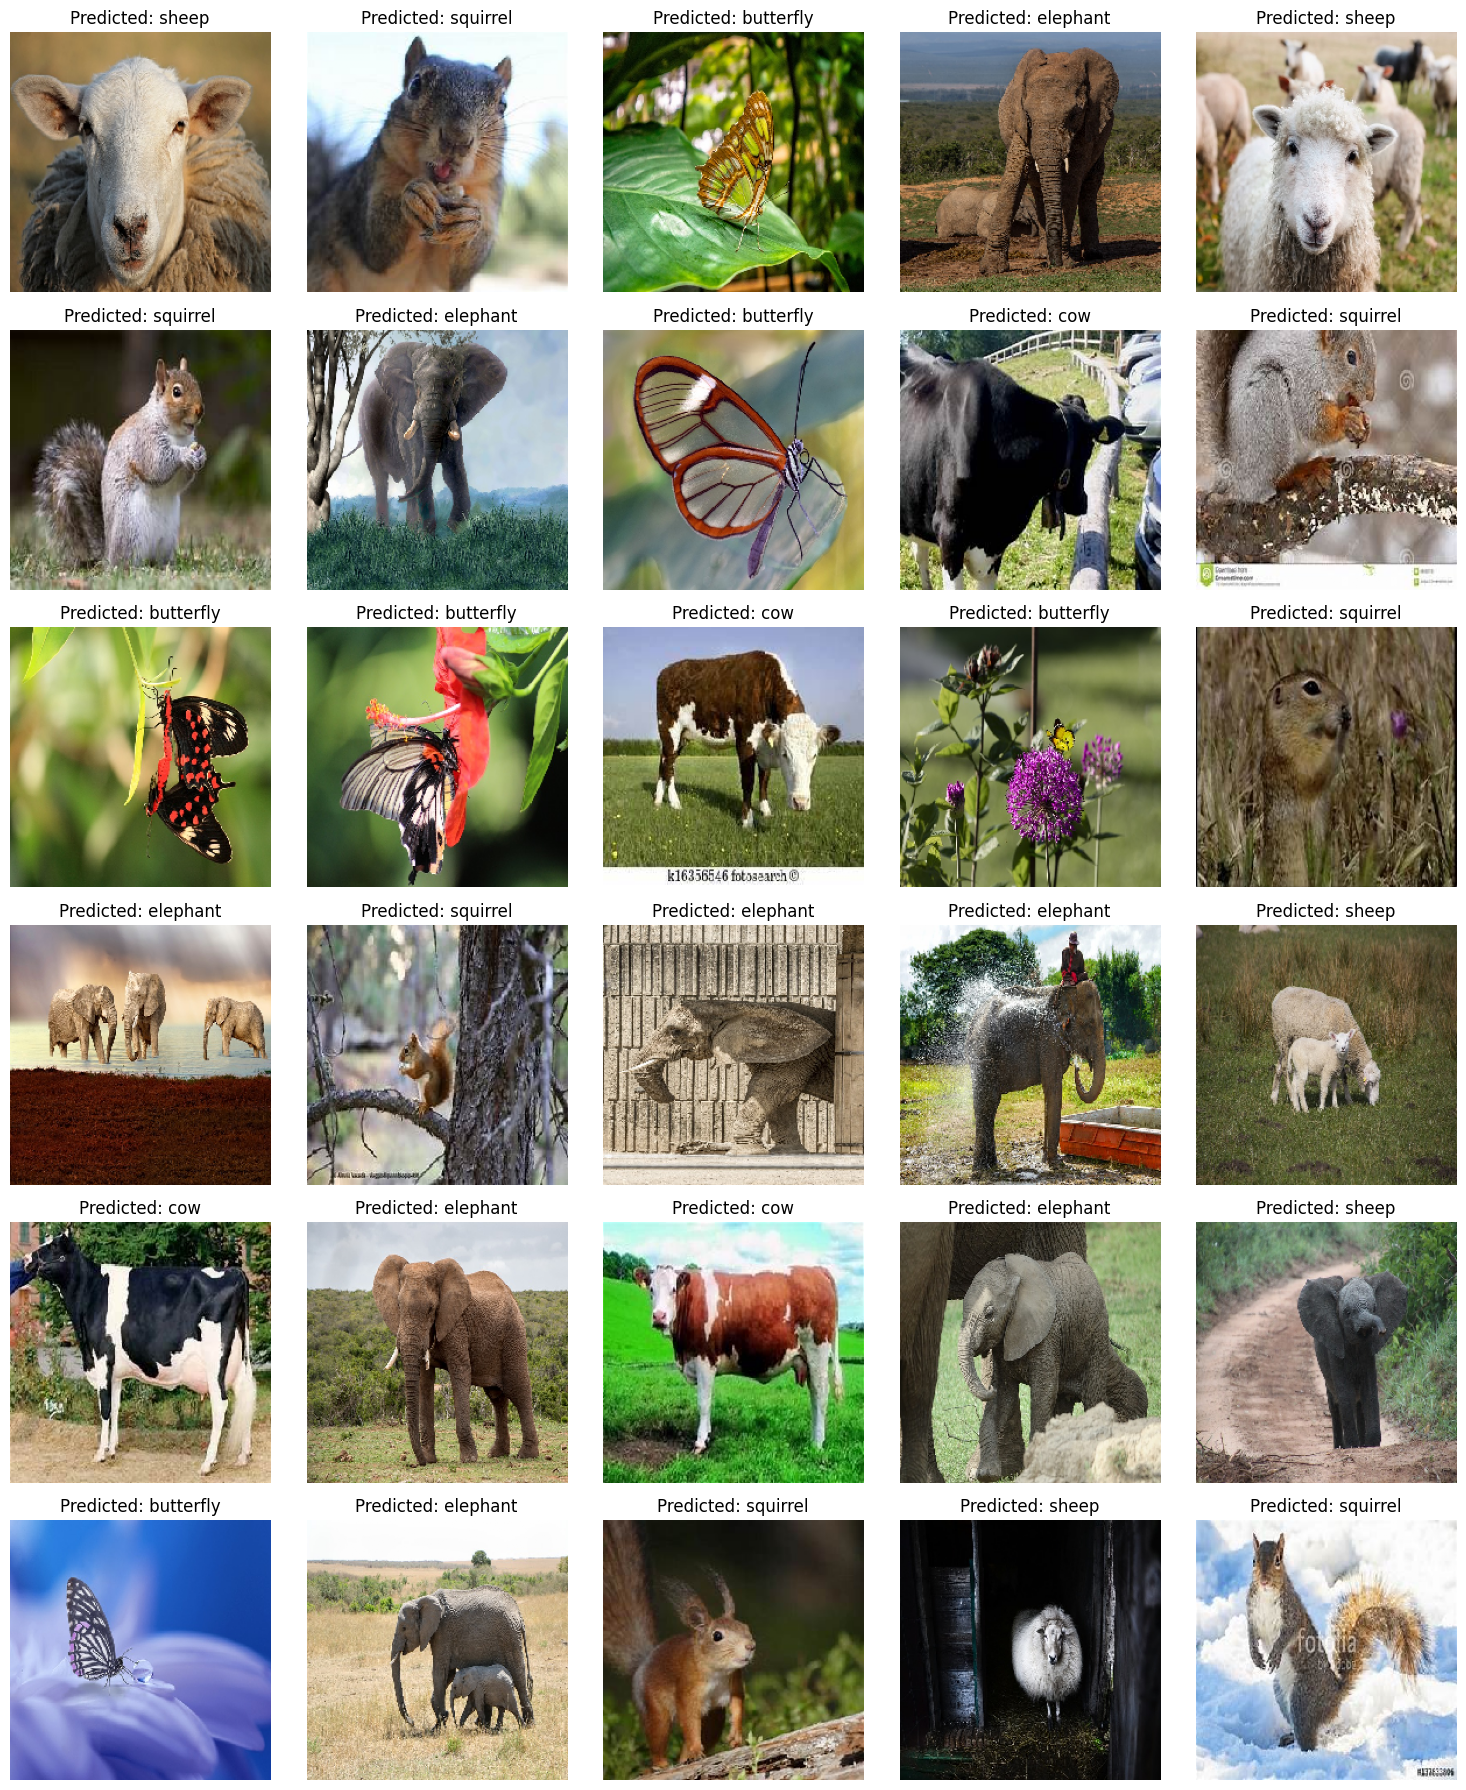

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import random

# Assuming you have your test directory path set
test_dir = '/kaggle/input/animal-dataset/animal_dataset_intermediate/test'  # Replace with your test data path

# Define the image size (must match model input size)
img_size = (224, 224)

# Mapping of original labels to English
label_mapping = {
    "elefante": "elephant",
    "farfalla": "butterfly",
    "mucca": "cow",
    "pecora": "sheep",
    "scoiattolo": "squirrel"
}

# Function to load images from a directory (like your train data)
def load_images_from_directory(directory, img_size=(224, 224)):
    images = []
    filenames = []
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            img = image.load_img(file_path, target_size=img_size)
            img_array = image.img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
            images.append(img_array)
            filenames.append(filename)  # Store the file names for later display
        except Exception as e:
            print(f"Skipping file {file_path}, error: {e}")
    return np.array(images), filenames

# Load images from the test directory
X_test, filenames_test = load_images_from_directory(test_dir)

# List of animal classes as per your original labels
animal_classes = ['farfalla', 'pecora', 'scoiattolo', 'elefante', 'mucca']

# Select 30 random images
random_indices = random.sample(range(len(X_test)), 30)  # Get 30 random indices
X_test_random = X_test[random_indices]
filenames_random = [filenames_test[i] for i in random_indices]

# Function to plot image with predicted label
def plot_image_with_prediction(ax, image, prediction, animal_classes, label_mapping, filename):
    ax.imshow(image)
    predicted_index = np.argmax(prediction)
    predicted_label = animal_classes[predicted_index]  # Get the predicted label in original language
    predicted_label_english = label_mapping[predicted_label]  # Map to English name
    ax.set_title(f"Predicted: {predicted_label_english}")
    ax.axis('off')  # Hide axes

# Number of images per row
images_per_row = 5

# Create a subplot grid (5 columns)
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(15, 18))  # 6 rows, 5 columns

# Flatten axes array for easier iteration
axes = axes.flatten()

# Loop through the selected 30 random images and predict
for i in range(30):  # Loop through all 30 images
    prediction = model.predict(np.expand_dims(X_test_random[i], axis=0))  # Predict for each image
    plot_image_with_prediction(axes[i], X_test_random[i], prediction, animal_classes, label_mapping, filenames_random[i])  # Visualize image with prediction

# Adjust layout
plt.tight_layout()
plt.show()
